# Multi-Class Bird Species Classification

# 1. Importing the data

In [7]:
#Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pathlib
import os
import tensorflow as tf
import tensorflow_hub as hub
import random
import matplotlib.image as mpimg
import os
from fastai.vision import *
from fastai.metrics import *
from google.colab import files
from tensorflow import keras

In [8]:
# Set seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# !pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# Run this to select the kaggle.json file containing the API token
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fredysantamaria","key":"7d6950fe7f4ea7570199da80809433a0"}'}

In [10]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Jun  7 21:08 kaggle.json


In [11]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [12]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
# # List available datasets.
# !kaggle datasets list
!kaggle datasets list -s birds

ref                                                      title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpiosenka/100-bird-species                               BIRDS 525  SPECIES- IMAGE CLASSIFICATION           2GB  2023-04-20 13:49:44          45009        999  0.9411765        
zhangjuefei/birds-bones-and-living-habits                Birds' Bones and Living Habits                    10KB  2017-01-18 03:53:49           4074         81  0.88235295       
fleanend/birds-songs-numeric-dataset                     Birds' Songs Numeric Dataset                      25MB  2019-04-01 09:09:46           1651         34  0.9411765        
ichhadhari/indian-birds                                  Indian-Birds-Species-Image-Classification          5G

In [14]:
# Copy the bird species dataset locally.
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.96G/1.96G [00:23<00:00, 118MB/s]
100% 1.96G/1.96G [00:23<00:00, 88.8MB/s]


In [15]:
#Make sure the zip file is there
!ls

100-bird-species.zip  kaggle.json  sample_data


In [16]:
#Unzip file
!unzip 100-bird-species.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/WHITE TAILED TROPIC/120.jpg  
  inflating: train/WHITE TAILED TROPIC/121.jpg  
  inflating: train/WHITE TAILED TROPIC/122.jpg  
  inflating: train/WHITE TAILED TROPIC/123.jpg  
  inflating: train/WHITE TAILED TROPIC/124.jpg  
  inflating: train/WHITE TAILED TROPIC/125.jpg  
  inflating: train/WHITE TAILED TROPIC/126.jpg  
  inflating: train/WHITE TAILED TROPIC/127.jpg  
  inflating: train/WHITE TAILED TROPIC/128.jpg  
  inflating: train/WHITE TAILED TROPIC/129.jpg  
  inflating: train/WHITE TAILED TROPIC/130.jpg  
  inflating: train/WHITE TAILED TROPIC/131.jpg  
  inflating: train/WHITE TAILED TROPIC/132.jpg  
  inflating: train/WHITE TAILED TROPIC/133.jpg  
  inflating: train/WHITE TAILED TROPIC/134.jpg  
  inflating: train/WHITE TAILED TROPIC/135.jpg  
  inflating: train/WHITE TAILED TROPIC/136.jpg  
  inflating: train/WHITE TAILED TROPIC/137.jpg  
  inflating: train/WHITE TAILED TROPIC/138.jpg  
  inflating: train

In [17]:
#Make sure the files and folders are there
!ls

 100-bird-species.zip			     kaggle.json   train
 birds.csv				     sample_data   valid
'EfficientNetB0-525-(224 X 224)- 98.97.h5'   test


In [18]:
birds_df = pd.read_csv('birds.csv')
birds_df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [19]:
# List directories
train_dir = "train/"
test_dir = "test/"
valid_dir = "valid/"

In [20]:

def view_rand_image(directory, bird_class):
  #Create the entire path
  path = directory + bird_class

  #Get an image from the path
  image = random.sample(os.listdir(path), 1)

  image_path = path + "/" + image[0]

  #Plot the image
  img = mpimg.imread(image_path)
  plt.imshow(img)
  plt.title(bird_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img


Image shape: (224, 224, 3)


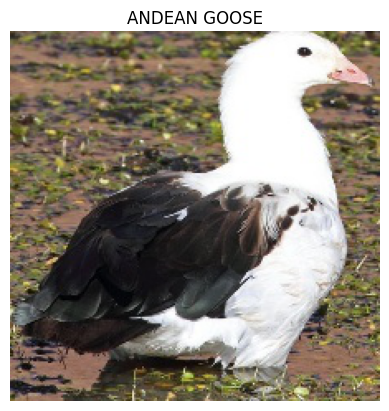

In [21]:
#View random image
img = view_rand_image(valid_dir, birds_df["labels"][4000])

# 2. Preprocess the images

In [22]:
import matplotlib.pyplot as plt
import pathlib, os, random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential

In [23]:
#Rescale images
data_generator = ImageDataGenerator(rescale = 1./255)


#Create batches
BATCH_SIZE =32
train_data = data_generator.flow_from_directory(directory = train_dir,
                                               batch_size= BATCH_SIZE,
                                               target_size= (224,224),
                                               class_mode = "categorical")

test_data = data_generator.flow_from_directory(directory = test_dir,
                                               batch_size = BATCH_SIZE,
                                               target_size = (224,224),
                                               class_mode = "categorical")

val_data = data_generator.flow_from_directory(directory = valid_dir,
                                               batch_size = BATCH_SIZE,
                                               target_size = (224,224),
                                               class_mode = "categorical")

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [30]:
#Set the number of classes based on the output above
NUMBER_OF_CLASSES = len(train_data.class_indices)
NUMBER_OF_CLASSES

525

# 3. Create and fit the model

**Note:** running the next cell might take up to 30 minutes

In [25]:
#Check for GPU availability
import tensorflow as tf

def check_gpu_availability():
    if tf.config.list_physical_devices("GPU"):
        print("GPU available")
    else:
        print("GPU not available")
        
check_gpu_availability()

GPU available


In [26]:
#Set the number of epochs
from tensorflow.keras.callbacks import EarlyStopping
NUMBER_OF_EPOCHS = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [33]:

# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.InceptionV3(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. Pass the inputs
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 5. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation="softmax", name="output_layer")(x)

# 7. Combine the inputs with outputs into a model
model = tf.keras.Model(inputs, outputs)

# 8. Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["accuracy"])

# 9. Fit the model
history = model.fit(train_data,
                    epochs=NUMBER_OF_EPOCHS,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=int(0.25 * len(val_data)),
                    callbacks=[early_stopping])

Shape after passing inputs through base model: (None, 5, 5, 2048)
Shape after GlobalAveragePooling2D: (None, 2048)
Epoch 1/10
2645/2645 [==============================] - 289s 108ms/step - loss: 10.5894 - accuracy: 0.4792 - val_loss: 7.5417 - val_accuracy: 0.6484
Epoch 2/10
2645/2645 [==============================] - 275s 104ms/step - loss: 7.5553 - accuracy: 0.6728 - val_loss: 7.3676 - val_accuracy: 0.6859
Epoch 3/10
2645/2645 [==============================] - 240s 91ms/step - loss: 6.4868 - accuracy: 0.7363 - val_loss: 6.0811 - val_accuracy: 0.7594
Epoch 4/10
2645/2645 [==============================] - 236s 89ms/step - loss: 5.6369 - accuracy: 0.7740 - val_loss: 7.0317 - val_accuracy: 0.7453
Epoch 5/10
2645/2645 [==============================] - 245s 93ms/step - loss: 4.9261 - accuracy: 0.8024 - val_loss: 7.4562 - val_accuracy: 0.7266


In [34]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 525)               1075725   
                                                                 
Total params: 22,878,509
Trainable params: 1,075,725
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.evaluate(test_data)

In [36]:
# # Evaluate the model
# _, train_accuracy = model.evaluate(train_data, verbose=0)
_, test_accuracy = model.evaluate(test_data, verbose=0)
# print(f"Train Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

Test Accuracy: 77.90%


In [41]:
# Save the base model in h5 format
base_bird_model = model.save('base_bird_model.h5')

In [38]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

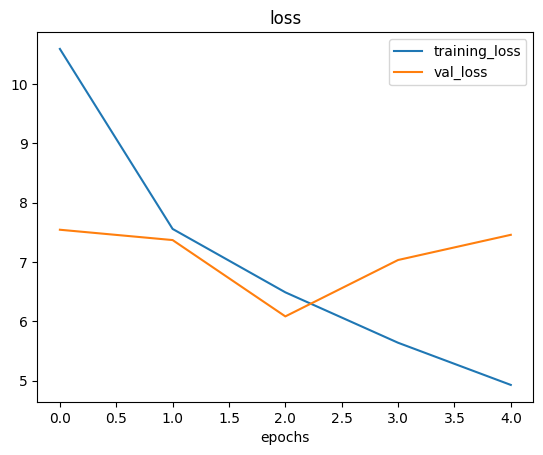

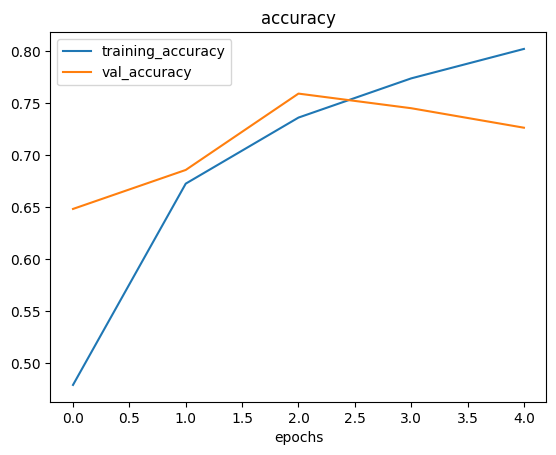

In [39]:
plot_loss_curves(history)

# 4. Freeze top layers of Base Model

In [49]:
#To begin fine-tuning lets start by setting the last 10 layers as trainable

base_model.trainable = True

# Un-freeze last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to compile model every time there is a change)
model.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), # when fine-tuning you typically want to lower lr by 10x
                 metrics = ["accuracy"] )

In [50]:
# Check which layers are trainable
for layer_number, layer in enumerate(model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 conv2d_376 False
2 batch_normalization_376 False
3 activation_376 False
4 conv2d_377 False
5 batch_normalization_377 False
6 activation_377 False
7 conv2d_378 False
8 batch_normalization_378 False
9 activation_378 False
10 max_pooling2d_16 False
11 conv2d_379 False
12 batch_normalization_379 False
13 activation_379 False
14 conv2d_380 False
15 batch_normalization_380 False
16 activation_380 False
17 max_pooling2d_17 False
18 conv2d_384 False
19 batch_normalization_384 False
20 activation_384 False
21 conv2d_382 False
22 conv2d_385 False
23 batch_normalization_382 False
24 batch_normalization_385 False
25 activation_382 False
26 activation_385 False
27 average_pooling2d_36 False
28 conv2d_381 False
29 conv2d_383 False
30 conv2d_386 False
31 conv2d_387 False
32 batch_normalization_381 False
33 batch_normalization_383 False
34 batch_normalization_386 False
35 batch_normalization_387 False
36 activation_381 False
37 activation_383 False
38 activation_386 False
39 activati

In [51]:
# Now we have unfrozen some of the layers on the top 
print(len(model.trainable_variables))

2


# 5. Fine-Tuning and Refitting

In [52]:
check_gpu_availability()

GPU available


In [53]:
fine_tune_epochs = NUMBER_OF_EPOCHS + 1

# Refit the model
history_2 = model.fit(train_data,
                       epochs = fine_tune_epochs,
                       validation_data = val_data,
                       validation_steps = int(0.25*len(val_data)),
                       initial_epoch =  history.epoch[-1],
                      callbacks=[early_stopping]) # Start the epoch where it left before

Epoch 5/11
2645/2645 [==============================] - 263s 98ms/step - loss: 1.4578 - accuracy: 0.9074 - val_loss: 2.5473 - val_accuracy: 0.8516
Epoch 6/11
2645/2645 [==============================] - 237s 89ms/step - loss: 0.9297 - accuracy: 0.9290 - val_loss: 2.4190 - val_accuracy: 0.8516
Epoch 7/11
2645/2645 [==============================] - 236s 89ms/step - loss: 0.6865 - accuracy: 0.9393 - val_loss: 2.0387 - val_accuracy: 0.8828
Epoch 8/11
2645/2645 [==============================] - 235s 89ms/step - loss: 0.5205 - accuracy: 0.9479 - val_loss: 2.1711 - val_accuracy: 0.8719
Epoch 9/11
2645/2645 [==============================] - 240s 91ms/step - loss: 0.4036 - accuracy: 0.9545 - val_loss: 1.6794 - val_accuracy: 0.8625
Epoch 10/11
2645/2645 [==============================] - 235s 89ms/step - loss: 0.3205 - accuracy: 0.9594 - val_loss: 1.8197 - val_accuracy: 0.8672
Epoch 11/11
2645/2645 [==============================] - 236s 89ms/step - loss: 0.2545 - accuracy: 0.9653 - val_loss:

In [54]:
# # Evaluate the model
_, test_accuracy = model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2%}")

Test Accuracy: 90.40%


In [55]:
#Save the model
tuned_model = model.save('tuned_bird_model.h5')

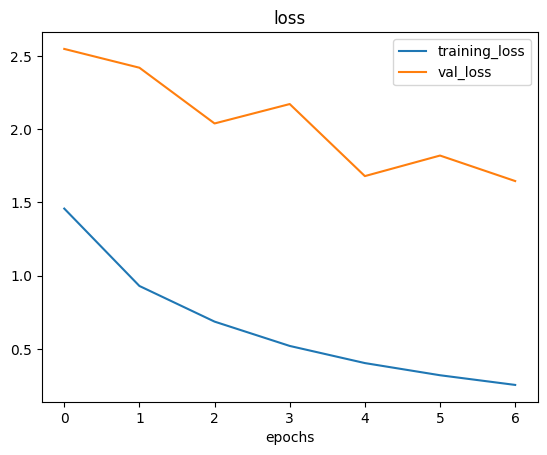

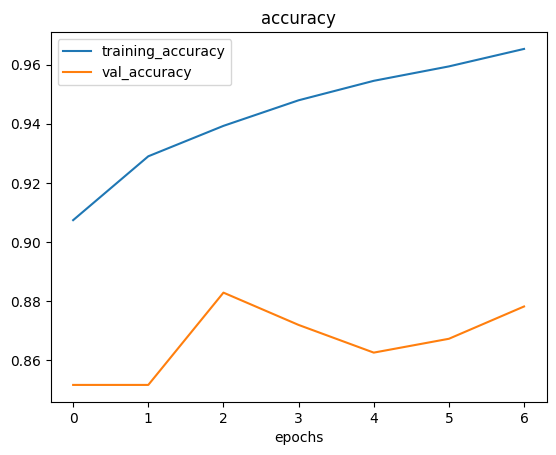

In [56]:
plot_loss_curves(history_2)